In [ ]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support

from google.colab import drive
drive.mount("/content/drive")

RANDOM_STATE = 42
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 4)


BASE_DIR = "/content/drive/MyDrive/Semeval_Polar"
DATA_DIR = os.path.join(BASE_DIR, "Data")
OUT_DIR  = os.path.join(BASE_DIR, "Submissions")
os.makedirs(OUT_DIR, exist_ok=True)

# ✅ Subtask-2 için dosya adını buraya yaz (Drive'daki gerçek isme göre)
TRAIN_PATH = os.path.join(DATA_DIR, "tur_subtask2.csv")     # <-- bunu gerekirse değiştir
TEST_PATH  = os.path.join(DATA_DIR, "tur_subtask2_test.csv")# <-- varsa


print("Train exists?", os.path.exists(TRAIN_PATH))
print("Test exists?", os.path.exists(TEST_PATH))
print("Out dir:", OUT_DIR)


Mounted at /content/drive
Train exists? True
Test exists? True
Out dir: /content/drive/MyDrive/Semeval_Polar/Submissions


In [ ]:
URL_RE     = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#\w+")
MULTI_WS   = re.compile(r"\s+")

def normalize_text(s: str) -> str:
    s = str(s).lower()
    s = URL_RE.sub(" <URL> ", s)
    s = MENTION_RE.sub(" <USER> ", s)
    s = HASHTAG_RE.sub(" <HASHTAG> ", s)
    s = MULTI_WS.sub(" ", s).strip()
    return s


In [ ]:
df = pd.read_csv(TRAIN_PATH)

print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head(3))

required = {"id", "text"}
if not required.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required - set(df.columns)}")

df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0].copy()
df["text_norm"] = df["text"].apply(normalize_text)

# ✅ Label kolonları (bu dataset'te bunlar var)
label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
missing = [c for c in label_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing label cols in train: {missing}")

# (Opsiyonel) polarization kolonu varsa filtrele
df2 = df.copy()
if "polarization" in df2.columns:
    before = len(df2)
    df2["polarization"] = pd.to_numeric(df2["polarization"], errors="coerce")
    df2 = df2[df2["polarization"] == 1].copy()
    print(f"Filtered polarization==1: {before} -> {len(df2)}")
else:
    print("No 'polarization' column (OK for this Subtask-2 dataset).")

X = df2["text_norm"].tolist()
Y = df2[label_cols].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int).values

print("X:", len(X), "| Y shape:", Y.shape)
print("Positives per label:", {c:int(Y[:,i].sum()) for i,c in enumerate(label_cols)})


Shape: (2364, 7)
Columns: ['id', 'text', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']


,id,text,political,racial/ethnic,religious,gender/sexual,other
0,tur_153d607a6d1a1130e696a94db6588075,Çıldırmam an meselesi Ben eskiden dövme yaptır...,0,0,0,0,0
1,tur_67a124df33f922df9430d8510716173f,2 Yurtlarını işgal ettiği mazlum v e masum Fil...,1,1,1,0,0
2,tur_0b8d62766d1198185bda9f3940e2d121,@USER Bereket Versin. İHA’ dan ateş edildiğind...,0,0,0,0,0


No 'polarization' column (OK for this Subtask-2 dataset).
X: 2364 | Y shape: (2364, 5)
Positives per label: {'political': 1057, 'racial/ethnic': 400, 'religious': 360, 'gender/sexual': 113, 'other': 114}


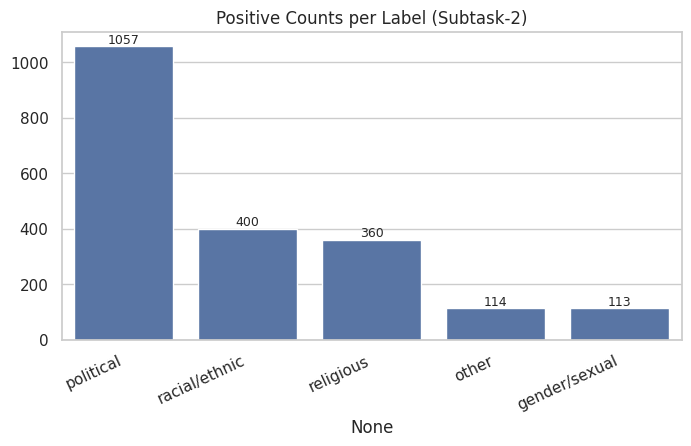

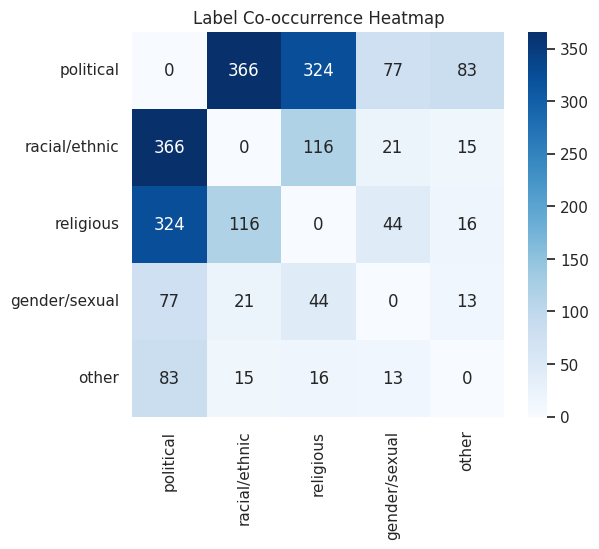

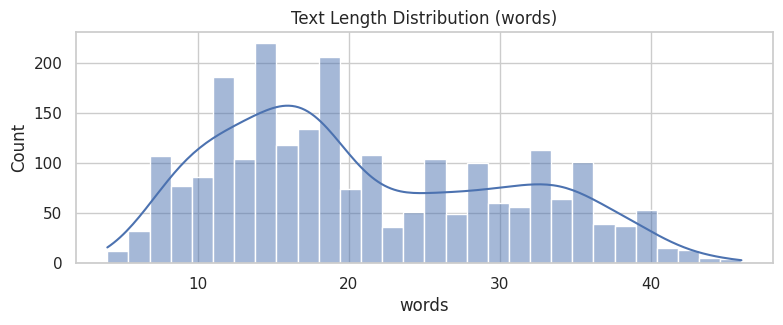

In [ ]:
# Label positive counts
pos_counts = pd.Series({c: int(Y[:, i].sum()) for i, c in enumerate(label_cols)}).sort_values(ascending=False)

plt.figure(figsize=(8,4))
ax = sns.barplot(x=pos_counts.index, y=pos_counts.values)
plt.title("Positive Counts per Label (Subtask-2)")
plt.xticks(rotation=25, ha="right")
for i, v in enumerate(pos_counts.values):
    ax.text(i, v + max(pos_counts.values)*0.01, str(v), ha="center", fontsize=9)
plt.show()

# Co-occurrence
cooc = (Y.T @ Y).astype(int)
np.fill_diagonal(cooc, 0)
plt.figure(figsize=(6,5))
sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_cols, yticklabels=label_cols)
plt.title("Label Co-occurrence Heatmap")
plt.show()

# Text length
lens = pd.Series([len(t.split()) for t in X])
plt.figure(figsize=(9,3))
sns.histplot(lens, bins=30, kde=True)
plt.title("Text Length Distribution (words)")
plt.xlabel("words")
plt.show()


In [ ]:
X_train, X_dev, Y_train, Y_dev = train_test_split(
    X, Y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train:", len(X_train), "Dev:", len(X_dev))


Train: 1891 Dev: 473


In [ ]:
word = TfidfVectorizer(analyzer="word", ngram_range=(1,2), max_features=200_000, min_df=1)
char = TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=200_000, min_df=1)

pre = ColumnTransformer(
    transformers=[
        ("word", word, "text_norm"),
        ("char", char, "text_norm"),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

clf = OneVsRestClassifier(
    LogisticRegression(
        max_iter=1200,
        class_weight="balanced",
        solver="liblinear",
        random_state=RANDOM_STATE
    )
)

model = Pipeline([
    ("prep", pre),
    ("clf", clf)
])

train_df = pd.DataFrame({"text_norm": X_train})
dev_df   = pd.DataFrame({"text_norm": X_dev})

model.fit(train_df, Y_train)
print("Baseline++ trained ✅")


Baseline++ trained ✅


In [ ]:
# OneVsRest -> list of estimators, each has predict_proba
proba_list = [est.predict_proba(model.named_steps["prep"].transform(dev_df))[:, 1]
             for est in model.named_steps["clf"].estimators_]
P_dev = np.vstack(proba_list).T  # (n, L)

Y_pred_05 = (P_dev >= 0.5).astype(int)

micro = f1_score(Y_dev, Y_pred_05, average="micro", zero_division=0)
macro = f1_score(Y_dev, Y_pred_05, average="macro", zero_division=0)
print("Dev Micro-F1 @0.5:", round(micro, 4))
print("Dev Macro-F1 @0.5:", round(macro, 4))

print("\nPer-label report (@0.5):")
print(classification_report(Y_dev, Y_pred_05, target_names=label_cols, zero_division=0, digits=4))


Dev Micro-F1 @0.5: 0.5785
Dev Macro-F1 @0.5: 0.3239

Per-label report (@0.5):
               precision    recall  f1-score   support

    political     0.7017    0.7489    0.7245       223
racial/ethnic     0.7500    0.3896    0.5128        77
    religious     0.5500    0.1528    0.2391        72
gender/sexual     0.6667    0.0800    0.1429        25
        other     0.0000    0.0000    0.0000        28

    micro avg     0.6977    0.4941    0.5785       425
    macro avg     0.5337    0.2743    0.3239       425
 weighted avg     0.6365    0.4941    0.5220       425
  samples avg     0.3576    0.2766    0.2990       425



In [ ]:
def best_thresholds_per_label(P, Y_true, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)  # 0.05 step ~ hızlı ve yeterli
    L = Y_true.shape[1]
    best_thr = np.zeros(L)
    best_f1  = np.zeros(L)

    for j in range(L):
        yj = Y_true[:, j]
        if yj.sum() == 0:
            best_thr[j] = 0.5
            best_f1[j]  = 0.0
            continue

        f1s = []
        for t in grid:
            pred = (P[:, j] >= t).astype(int)
            f1s.append(f1_score(yj, pred, zero_division=0))
        k = int(np.argmax(f1s))
        best_thr[j] = float(grid[k])
        best_f1[j]  = float(f1s[k])

    return best_thr, best_f1

thr, best_f1_each = best_thresholds_per_label(P_dev, Y_dev)

print("Best thresholds:", {label_cols[i]: round(thr[i], 2) for i in range(len(label_cols))})
print("Best per-label F1:", {label_cols[i]: round(best_f1_each[i], 3) for i in range(len(label_cols))})

Y_pred_thr = (P_dev >= thr).astype(int)

micro_t = f1_score(Y_dev, Y_pred_thr, average="micro", zero_division=0)
macro_t = f1_score(Y_dev, Y_pred_thr, average="macro", zero_division=0)
print("\nDev Micro-F1 (tuned):", round(micro_t, 4))
print("Dev Macro-F1 (tuned):", round(macro_t, 4))


Best thresholds: {'political': np.float64(0.45), 'racial/ethnic': np.float64(0.45), 'religious': np.float64(0.35), 'gender/sexual': np.float64(0.3), 'other': np.float64(0.25)}
Best per-label F1: {'political': np.float64(0.748), 'racial/ethnic': np.float64(0.559), 'religious': np.float64(0.427), 'gender/sexual': np.float64(0.311), 'other': np.float64(0.194)}

Dev Micro-F1 (tuned): 0.5917
Dev Macro-F1 (tuned): 0.4479


,label,precision,recall,f1,support,thr
0,political,0.658703,0.865471,0.748062,223,0.45
1,racial/ethnic,0.606061,0.519481,0.559441,77,0.45
2,religious,0.323741,0.625000,0.426540,72,0.35
3,gender/sexual,0.350000,0.280000,0.311111,25,0.30
4,other,0.159091,0.250000,0.194444,28,0.25


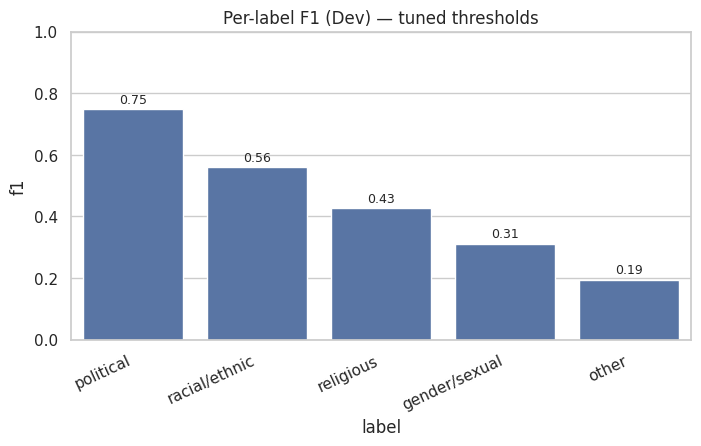

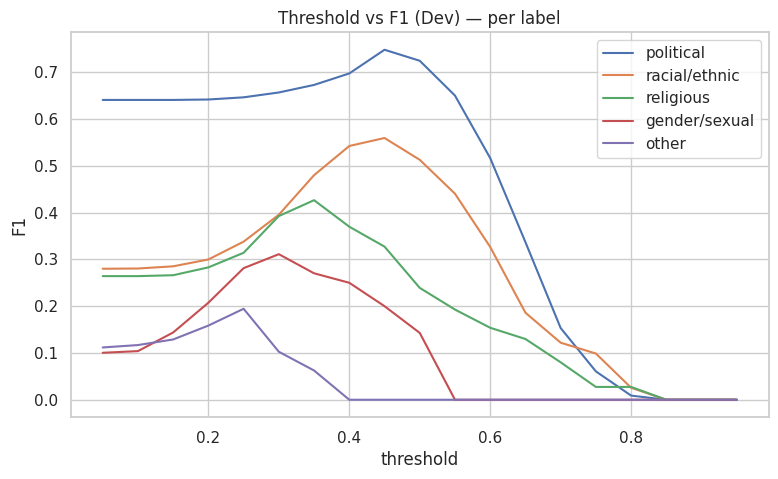

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

p, r, f1, s = precision_recall_fscore_support(Y_dev, Y_pred_thr, average=None, zero_division=0)

rep = pd.DataFrame({
    "label": label_cols,
    "precision": p,
    "recall": r,
    "f1": f1,
    "support": s,
    "thr": thr
}).sort_values("f1", ascending=False)

display(rep)

# PRF barplot (F1)
plt.figure(figsize=(8,4))
ax = sns.barplot(data=rep, x="label", y="f1")
plt.title("Per-label F1 (Dev) — tuned thresholds")
plt.ylim(0, 1)
plt.xticks(rotation=25, ha="right")
for i, row in enumerate(rep.itertuples()):
    ax.text(i, row.f1 + 0.02, f"{row.f1:.2f}", ha="center", fontsize=9)
plt.show()

# Threshold-F1 curve for each label
grid = np.linspace(0.05, 0.95, 19)
plt.figure(figsize=(9,5))
for j, lab in enumerate(label_cols):
    yj = Y_dev[:, j]
    if yj.sum() == 0:
        continue
    f1s = [f1_score(yj, (P_dev[:, j] >= t).astype(int), zero_division=0) for t in grid]
    plt.plot(grid, f1s, label=lab)
plt.title("Threshold vs F1 (Dev) — per label")
plt.xlabel("threshold")
plt.ylabel("F1")
plt.legend()
plt.show()


In [ ]:
# Final fit on ALL labeled data
all_df = pd.DataFrame({"text_norm": df2["text_norm"].tolist()})
model.fit(all_df, Y)

# Load test
df_test = pd.read_csv(TEST_PATH)
df_test["text"] = df_test["text"].astype(str).str.strip()
df_test = df_test[df_test["text"].str.len() > 0].copy()
df_test["text_norm"] = df_test["text"].apply(normalize_text)

if "id" not in df_test.columns:
    df_test["id"] = np.arange(len(df_test))

test_df = pd.DataFrame({"text_norm": df_test["text_norm"].tolist()})

# Proba on test
P_list = [est.predict_proba(model.named_steps["prep"].transform(test_df))[:, 1]
          for est in model.named_steps["clf"].estimators_]
P_test = np.vstack(P_list).T

Y_test_pred = (P_test >= thr).astype(int)

sub = pd.DataFrame({"id": df_test["id"]})
for j, lab in enumerate(label_cols):
    sub[lab] = Y_test_pred[:, j].astype(int)

out_path = os.path.join(OUT_DIR, "subtask2_tr_baseline_predictions.csv")
sub.to_csv(out_path, index=False)

print("Saved:", out_path)
display(sub.head(10))


Saved: /content/drive/MyDrive/Semeval_Polar/Submissions/subtask2_tr_baseline_predictions.csv


,id,political,racial/ethnic,religious,gender/sexual,other
0,tur_51d5ae56681ac60f71111d88cce7c322,0,0,0,0,1
1,tur_a942b7b57ea21f83cba49c05b3a8dc06,1,0,0,0,1
2,tur_2560161367a0747f32070ba1a54be275,1,0,1,0,0
3,tur_2a45e8c804463256a9dc04328fa867c1,0,0,0,0,0
4,tur_77bd1dd03a347a23f64ae022ad17f53a,1,1,0,0,0
5,tur_ad585591cb519e07dbe602ce07c390fc,1,0,0,0,0
6,tur_f376d5c18b33dd5056271da352c400b4,1,1,1,0,0
7,tur_2ae6522870f36f45c728cff04d381fdc,1,0,1,0,0
8,tur_f0cf95b93214f3a7030187151b2ad23f,0,0,1,0,0
9,tur_e93d64ab0054e0c3b4920f0e191c3022,1,1,1,0,0
